# Loading data & Time conversion

In the TrainActivities.csv, all time-related columns are in JST but doesn't contain UTC information. 

While all accelerometer data are took in different time zones. 

Thus we need to add UTC information to activity labels dataset which is UTC+09:00

And convert all accelerometer data into the same timezone which is UTC+09:00

## Load activity labels data

In [3]:
# load activity data
import pandas as pd

act_dir = '../data/TrainingDataPD25/TrainActivities.csv'

def read_act_df(base_dir, time_cols=['Started', 'Finished', 'Updated']):
    act_df = pd.read_csv(base_dir)
    act_df = act_df.dropna(subset=time_cols)

    for col in time_cols:
        act_df[col] = pd.to_datetime(act_df[col], format='%Y/%m/%d %H:%M')
        if act_df[col].isna().any():
            raise ValueError(f"Column '{col}' contains NaN or unparseable datetime values.")
        act_df[col] = act_df[col].dt.tz_localize('UTC+09:00')

    return act_df

act_df = read_act_df(act_dir)
act_df.head(10)

,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
0,1130251,2806,1 (FACING camera) Sit and stand,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00,U22
1,1130254,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00,U22
2,1130257,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00,U22
3,1130261,2806,1 (FACING camera) Sit and stand,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00,U22
4,1130292,2806,1 (FACING camera) Sit and stand,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
5,1130293,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
6,1130294,2808,3 Stand up from chair - both hands with SHAKING,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
7,1130306,2806,1 (FACING camera) Sit and stand,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00,U1
8,1136872,2806,1 (FACING camera) Sit and stand,2024-09-03 19:56:00+09:00,2024-09-03 19:56:00+09:00,2024-09-03 19:56:00+09:00,U22
9,1136878,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-03 19:56:00+09:00,2024-09-03 19:57:00+09:00,2024-09-03 19:57:00+09:00,U22


## Load users acceleration data
This dataset contains more than one timezones, and all of them include the UTC offset.

In [19]:
# Load all csv files into one dataframe
import os
import glob

base_dir = '/Users/tptn/MachineLearning/tremor_challenge2/data/TrainingDataPD25/users_timeXYZ/users'
headers = ['id', 'datetime', 'x', 'y', 'z']

def read_users_df(base_dir, headers):
    """ Read all csv files in users folder 
    Return:
        users_df: a DataFrame contains all csv files
    Args:
        base_dir: base folder to csv files
        headers: headers for csv files
    """
    df_list = [] # to store all csv files
    for id in os.listdir(base_dir):
        path = os.path.join(base_dir, id)

        if os.path.isdir(path):
            files = glob.glob(os.path.join(path, '*.csv'))

            for f in files:
                df = pd.read_csv(f, header=None, names=headers) # load csv
                df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%dT%H:%M:%S.%f%z') # conver to datetime
                tz = df['datetime'].dt.tz # get the timezone
                if tz != 'UTC+09:00':
                    df['datetime'] = df['datetime'].dt.tz_convert('UTC+09:00')
                df_list.append(df)
    users_df = pd.concat(df_list, ignore_index=True)
    return users_df

users_df = read_users_df(base_dir, headers)

In [76]:
# check if there is different timezone in datetime column
unique_timezones = users_df['datetime'].apply(lambda x: x.tz).unique()
print(unique_timezones)

[datetime.timezone(datetime.timedelta(seconds=32400))]


From the above result, we can know that the acceleration data is successfully read and converted to JST

# Explore the data
## Plot each activity count per user id

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_act_count_per_user(df, user_col='Subject', act_col='Activity Type'):
    # Group by Subject and Activity Type, then count occurrences
    activity_counts = df.groupby([user_col, act_col]).size().reset_index(name='Count')

    # Plot
    plt.figure(figsize=(14, 6))
    sns.barplot(data=activity_counts, x=user_col, y='Count', hue=act_col)
    plt.title('Count of Activities Per User')
    plt.xticks(rotation=45)
    plt.legend(title='Activity Type', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

Before drop duplicated rows


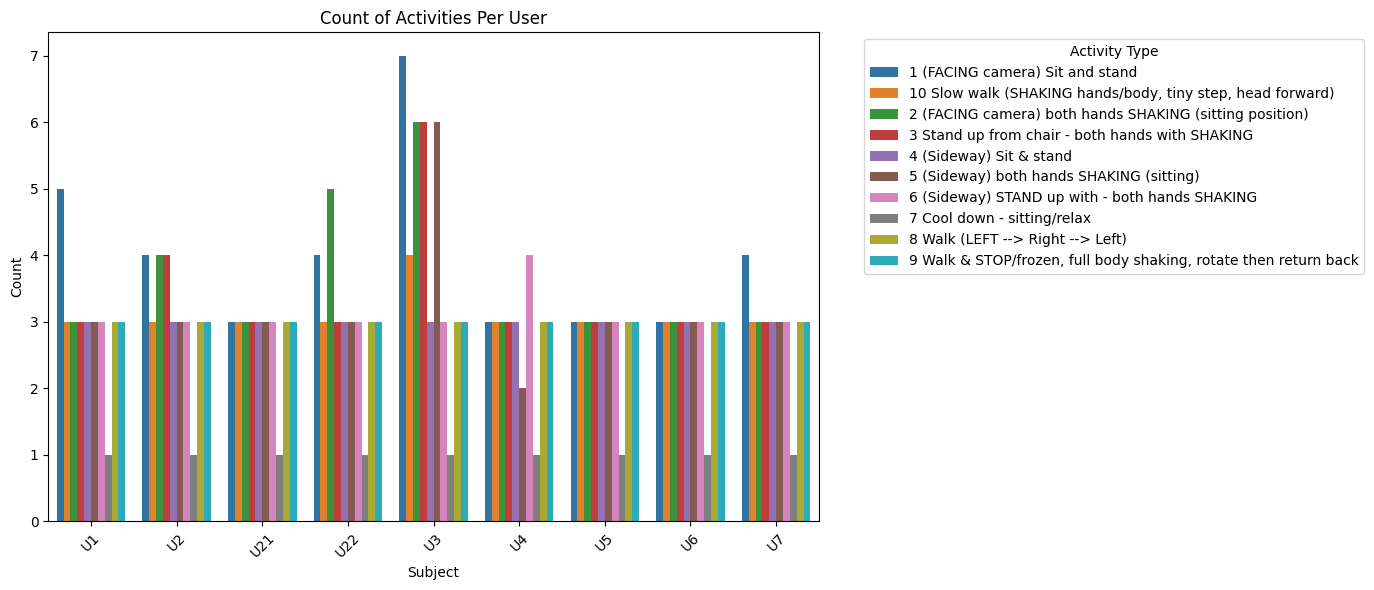

In [46]:
print('Before drop duplicated rows')
plot_act_count_per_user(act_df)

## Drop duplicated rows in activity labels data

before drop: (275, 7)
after drop: (203, 7)
After drop duplicated rows


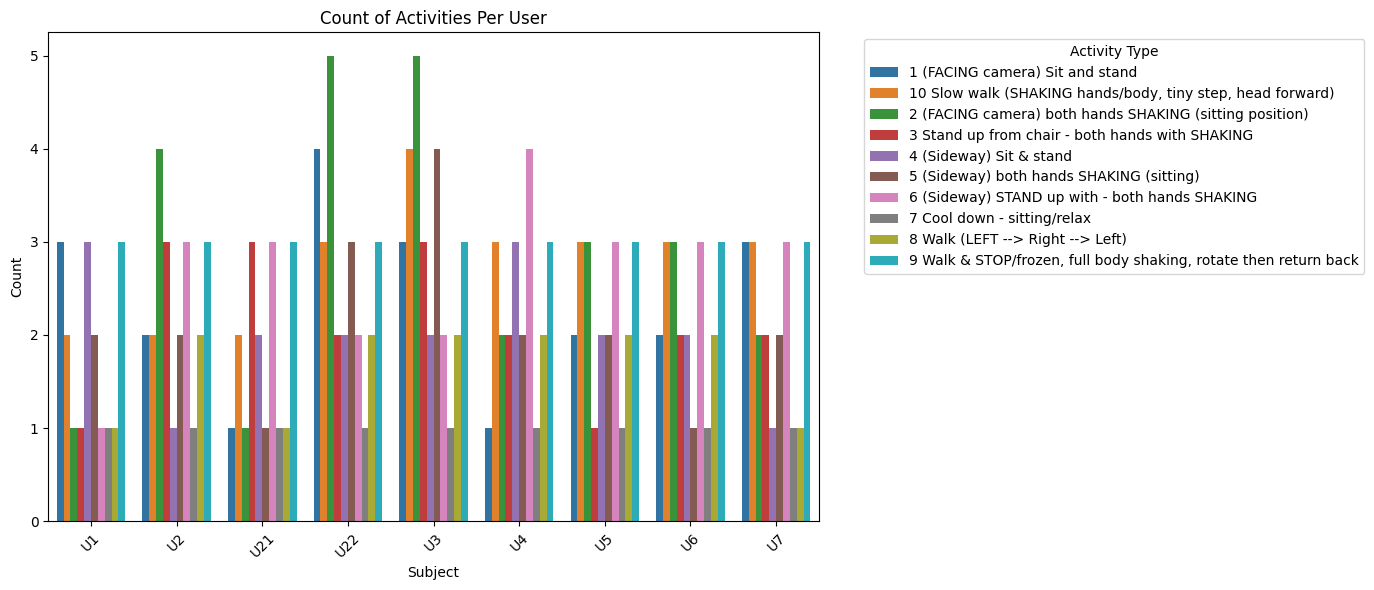

In [47]:
cols=['Activity Type', 'Started', 'Finished', 'Subject']
drop_df = act_df.drop_duplicates(subset=cols, keep='last').sort_values(by=['Started']).reset_index(drop=True)
print(f'before drop: {act_df.shape}')
print(f'after drop: {drop_df.shape}')
print('After drop duplicated rows')
plot_act_count_per_user(drop_df)

## Hypothesis 1: Multiple users have activities with the exact same Started

In [11]:
# Step 1: Find duplicated start times
dup_df = drop_df[drop_df.duplicated(subset=['Started'], keep=False)].drop(columns=['ID'])

# Step 2: Group by 'Started' and aggregate unique subjects
grouped = dup_df.groupby('Started')['Subject'].nunique().reset_index()

# Step 3: Filter where more than one unique subject exists
same_time_different_users = grouped[grouped['Subject'] > 1]

# Optional: See which users are involved
detailed_view = dup_df[dup_df['Started'].isin(same_time_different_users['Started'])]

# Print results
print(same_time_different_users)
print(detailed_view.sort_values(by='Started'))

Empty DataFrame
Columns: [Started, Subject]
Index: []
Empty DataFrame
Columns: [Activity Type ID, Activity Type, Started, Finished, Updated, Subject]
Index: []


**Answer: hypothesis 1 is wrong**

## Hypothesis 2: There are multiple activities at the same time

In [12]:
# Group by 'Started' and count how many activities occur at each time
activity_counts = drop_df.groupby('Started').size().reset_index(name='ActivityCount')

# Filter for times with more than 1 activity
multiple_activities = activity_counts[activity_counts['ActivityCount'] > 1]

# View the actual records from the original DataFrame
actual_activities = drop_df[drop_df['Started'].isin(multiple_activities['Started'])]

# Show result
display(multiple_activities)
display(actual_activities.sort_values(by='Started'))

,Started,ActivityCount
4,2024-09-02 06:42:00+09:00,3
6,2024-09-03 19:56:00+09:00,2
8,2024-09-03 20:00:00+09:00,3
10,2024-09-03 20:02:00+09:00,3
11,2024-09-03 20:03:00+09:00,2
13,2024-09-03 20:05:00+09:00,2
15,2024-09-03 20:07:00+09:00,2
23,2024-09-03 20:21:00+09:00,2
28,2024-09-03 20:26:00+09:00,2
31,2024-09-03 20:33:00+09:00,2


,ID,Activity Type ID,Activity Type,Started,Finished,Updated,Subject
4,1130292,2806,1 (FACING camera) Sit and stand,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
5,1130293,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
6,1130294,2808,3 Stand up from chair - both hands with SHAKING,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00,U2
8,1136872,2806,1 (FACING camera) Sit and stand,2024-09-03 19:56:00+09:00,2024-09-03 19:56:00+09:00,2024-09-03 19:56:00+09:00,U22
9,1136878,2807,2 (FACING camera) both hands SHAKING (sitting ...,2024-09-03 19:56:00+09:00,2024-09-03 19:57:00+09:00,2024-09-03 19:57:00+09:00,U22
...,...,...,...,...,...,...,...
193,1164169,2811,6 (Sideway) STAND up with - both hands SHAKING,2024-09-11 05:04:00+09:00,2024-09-11 05:04:00+09:00,2024-09-11 05:05:00+09:00,U7
194,1164171,2811,6 (Sideway) STAND up with - both hands SHAKING,2024-09-11 05:05:00+09:00,2024-09-11 05:05:00+09:00,2024-09-11 05:05:00+09:00,U7
195,1164172,2812,7 Cool down - sitting/relax,2024-09-11 05:05:00+09:00,2024-09-11 05:05:00+09:00,2024-09-11 05:05:00+09:00,U7
198,1164177,2814,"9 Walk & STOP/frozen, full body shaking, rotat...",2024-09-11 05:08:00+09:00,2024-09-11 05:08:00+09:00,2024-09-11 05:08:00+09:00,U7


**Answer: hypothesis 2 is correct**

# Matching activity labels with sensor data

In order to match the activity labels with the sensor data, we need to consider whether the timestamps in the sensor data are in the started and finished time of the activity or not. However, the started and finished in activity labels dataset do not contain any seconds, which makes no interval exists between started and finished.

Solution:
- Assume a activity started at H:min:00.000000 and finished at H:min:59.999999

## Adding interval between Started and Finished

In [14]:
def add_duration(df, start_col='Started', end_col='Finished'):
    """Adding interval between two given cols
    
    Return:
        DataFrame: a dataframe with added interval between two columns

    Args:
        df (DataFrame): original dataframe
    """
    df_cp = df.copy()

    df_cp[start_col] = df_cp[start_col].dt.floor('s')
    df_cp[end_col] = df_cp[end_col].dt.floor('s') + pd.Timedelta(minutes=1) - pd.Timedelta(microseconds=1)

    return df_cp

duration_added_df = add_duration(drop_df)
duration_added_df[['Started', 'Finished']].head(10)

,Started,Finished
0,2024-09-02 06:16:00+09:00,2024-09-02 06:16:59.999999+09:00
1,2024-09-02 06:17:00+09:00,2024-09-02 06:17:59.999999+09:00
2,2024-09-02 06:18:00+09:00,2024-09-02 06:18:59.999999+09:00
3,2024-09-02 06:20:00+09:00,2024-09-02 06:20:59.999999+09:00
4,2024-09-02 06:42:00+09:00,2024-09-02 06:42:59.999999+09:00
5,2024-09-02 06:42:00+09:00,2024-09-02 06:42:59.999999+09:00
6,2024-09-02 06:42:00+09:00,2024-09-02 06:42:59.999999+09:00
7,2024-09-02 06:44:00+09:00,2024-09-02 06:44:59.999999+09:00
8,2024-09-03 19:56:00+09:00,2024-09-03 19:56:59.999999+09:00
9,2024-09-03 19:56:00+09:00,2024-09-03 19:57:59.999999+09:00


In [15]:
cols = ['Started', 'Finished']
print(f'Before adding interval:')
display(act_df[cols].head(10))
print(f'After adding interval:')
display(duration_added_df[cols].head(10))

Before adding interval:


,Started,Finished
0,2024-09-02 06:16:00+09:00,2024-09-02 06:16:00+09:00
1,2024-09-02 06:17:00+09:00,2024-09-02 06:17:00+09:00
2,2024-09-02 06:18:00+09:00,2024-09-02 06:18:00+09:00
3,2024-09-02 06:20:00+09:00,2024-09-02 06:20:00+09:00
4,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00
5,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00
6,2024-09-02 06:42:00+09:00,2024-09-02 06:42:00+09:00
7,2024-09-02 06:44:00+09:00,2024-09-02 06:44:00+09:00
8,2024-09-03 19:56:00+09:00,2024-09-03 19:56:00+09:00
9,2024-09-03 19:56:00+09:00,2024-09-03 19:57:00+09:00


After adding interval:


,Started,Finished
0,2024-09-02 06:16:00+09:00,2024-09-02 06:16:59.999999+09:00
1,2024-09-02 06:17:00+09:00,2024-09-02 06:17:59.999999+09:00
2,2024-09-02 06:18:00+09:00,2024-09-02 06:18:59.999999+09:00
3,2024-09-02 06:20:00+09:00,2024-09-02 06:20:59.999999+09:00
4,2024-09-02 06:42:00+09:00,2024-09-02 06:42:59.999999+09:00
5,2024-09-02 06:42:00+09:00,2024-09-02 06:42:59.999999+09:00
6,2024-09-02 06:42:00+09:00,2024-09-02 06:42:59.999999+09:00
7,2024-09-02 06:44:00+09:00,2024-09-02 06:44:59.999999+09:00
8,2024-09-03 19:56:00+09:00,2024-09-03 19:56:59.999999+09:00
9,2024-09-03 19:56:00+09:00,2024-09-03 19:57:59.999999+09:00


In [ ]:
def seg_df_per_act(users_df, act_df):
    """
    Segmenting the dataset into one dataframe per activity
    Description:
        Each activity will has its own dataframe, which contains all the timestamps and accelerometer data within the activity time range.

    Return:
        seg_list: list of df, one df contains acceleration data of corresponding activity label
        seg_label_list: list of label. one label correspond to one df in seg_list
    
    Args:
        users_df: one big DataFrame of acceleration data
        act_df: activity labels DataFrame
    """

    seg_label_list = []
    seg_list = []
    seg_subject_list = []
    
    for i in range(0, len(act_df)):
        started_at = act_df.iloc[i]['Started']
        finished_at = act_df.iloc[i]['Finished']

        seg = users_df[(users_df['datetime'] >= started_at) & (users_df['datetime'] <= finished_at)]
        # seg_label = act_df.iloc[i]['Activity Type']
        seg_label = act_df.iloc[i]['Activity Type ID']
        seg_subject = act_df.iloc[i]['Subject']

        # check if seq is not empty
        if len(seg) != 0:
            seg_list.append(seg)
            seg_label_list.append(seg_label)
            seg_subject_list.append(seg_subject)

    return seg_list, seg_label_list, seg_subject_list

In [22]:
seg_list, seg_label_list, seg_subject_list = seg_df_per_act(users_df, duration_added_df)
print(f'seg_list: {len(seg_list)}, seg_label_list: {len(seg_label_list)}')

seg_list: 199, seg_label_list: 199


# Feature Extraction

In [24]:
import numpy as np
from scipy.stats import iqr, skew, kurtosis

def zero_crossing_rate(signal):
    """Calculate zero crossing rate of a 1D numpy array"""
    return ((signal[:-1] * signal[1:]) < 0).sum() / len(signal)

def safe_corr(a, b):
    """Safely calculate correlation"""
    if len(a) < 2 or np.std(a) == 0 or np.std(b) == 0:
        return 0.0  # or np.nan if you prefer to filter later
    return np.corrcoef(a, b)[0, 1]

def get_feats(df, columns=['x', 'y', 'z']):
    """
    Extracting features from accelerometer data of each activity.

    Returns:
        feats: List of features (example: std_x, std_y, std_z, mean_x, ...)
    Args:
        df: dataframe
        columns: the accelerometer data
    Usages:
        feats_list = []
        for df in seg_list:
            feats_list.append(get_feats(df))
    """

    feats = []

    # Time domain features per axis
    for col in columns:
        data = df[col].values

        std_ = np.std(data, ddof=0)
        mean_ = np.mean(data)
        max_ = np.max(data)
        min_ = np.min(data)
        median_ = np.median(data)
        iqr_ = iqr(data)
        var_ = np.var(data)
        skew_ = skew(data)
        kurt_ = kurtosis(data)
        ptp_ = np.ptp(data)  # peak-to-peak (max - min)
        rms_ = np.sqrt(np.mean(data**2))
        zcr_ = zero_crossing_rate(data)

        feats.extend([
            std_, mean_, max_, min_, median_, iqr_,
            var_, skew_, kurt_, ptp_, rms_, zcr_
        ])

    # Signal Magnitude Area (SMA)
    mag = np.abs(df[columns]).sum(axis=1)
    sma = mag.sum() / len(df)
    feats.append(sma)

    # Correlation between axes
    corr_xy = safe_corr(df['x'], df['y'])
    corr_yz = safe_corr(df['y'], df['z'])
    corr_zx = safe_corr(df['z'], df['x'])
    
    feats.extend([corr_xy, corr_yz, corr_zx])

    return feats

## Segmentation using window sliding method

In [25]:
"""Segment using sliding window method

Returns:
    List: list of features per activity
Args:
    df: accelerometer data + activity label data
    wsize: window size [seconds]
    stride: how much the window slide
"""
def windowSeg(df, wsize, stride):
    features_list = []
    start_time = df['datetime'].min()
    end_time = df['datetime'].max()
    current_start = start_time

    while current_start + pd.Timedelta(seconds=wsize) <= end_time:
        current_end = current_start + pd.Timedelta(seconds=wsize)
        window = df[(df['datetime'] >= current_start) & (df['datetime'] < current_end)]
        if not window.empty:
            feats = get_feats(window)
            features_list.append(feats)
        current_start += pd.Timedelta(seconds=stride)

    return features_list

In [27]:
def process_segments(seg_list, seg_label_list, seg_subject_list, wsize=1, stride=0.5):
    all_features = []
    all_labels = []
    all_subjects = []

    for df, label, subject in zip(seg_list, seg_label_list, seg_subject_list):
        feats_list = windowSeg(df, wsize, stride)
        all_features.extend(feats_list)
        all_labels.extend([label] * len(feats_list))
        all_subjects.extend([subject] * len(feats_list))

    # Define feature names for columns
    base_features = ['std', 'mean', 'max', 'min', 'median', 'iqr', 'var', 'skew', 'kurt', 'ptp', 'rms', 'zcr']
    columns = [f'{stat}_{axis}' for axis in ['x', 'y', 'z'] for stat in base_features]
    columns += ['sma', 'corr_xy', 'corr_yz', 'corr_zx']

    features_df = pd.DataFrame(all_features, columns=columns)
    features_df['label'] = all_labels
    features_df['subject'] = all_subjects

    return features_df

In [163]:
WINDOW_SIZE = 0.5 # window size = 1s
OVERLAP_RATE = 0.5 * WINDOW_SIZE # overlap 50% window size

all_in_one_df = process_segments(seg_list, seg_label_list, seg_subject_list, wsize=WINDOW_SIZE, stride=WINDOW_SIZE - OVERLAP_RATE)

In [164]:
print(all_in_one_df.shape)
print(all_in_one_df.isna().sum().sum())
all_in_one_df.dropna(inplace=True)
all_in_one_df.head(10)
print(all_in_one_df['subject'].unique().shape)
print(all_in_one_df.head(2))

(63913, 42)
8
(9,)
   std_x  mean_x  max_x  min_x  median_x  iqr_x  var_x  skew_x  kurt_x  ptp_x  \
0   0.61    2.31   3.42   1.49      2.18   0.90   0.37    0.47   -1.02   1.93   
1   1.04    1.61   3.67  -0.08      1.78   1.35   1.09    0.12   -0.44   3.75   

   ...  kurt_z  ptp_z  rms_z  zcr_z   sma  corr_xy  corr_yz  corr_zx  label  \
0  ...   -0.54   1.13   4.92   0.00 14.93    -0.54    -0.83     0.15   2806   
1  ...   -1.13   2.09   5.19   0.00 14.63     0.90    -0.64    -0.53   2806   

   subject  
0       U2  
1       U2  

[2 rows x 42 columns]


## Correlation between features

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_corr(df, drop_cols=['label', 'subject']):
    # Drop label for correlation
    corr_matrix = df.drop(columns=drop_cols).corr()

    # Plot correlation heatmap
    plt.figure(figsize=(16, 12))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False, fmt=".2f")
    plt.title("Feature Correlation Heatmap (excluding label)")
    plt.tight_layout()
    plt.show()

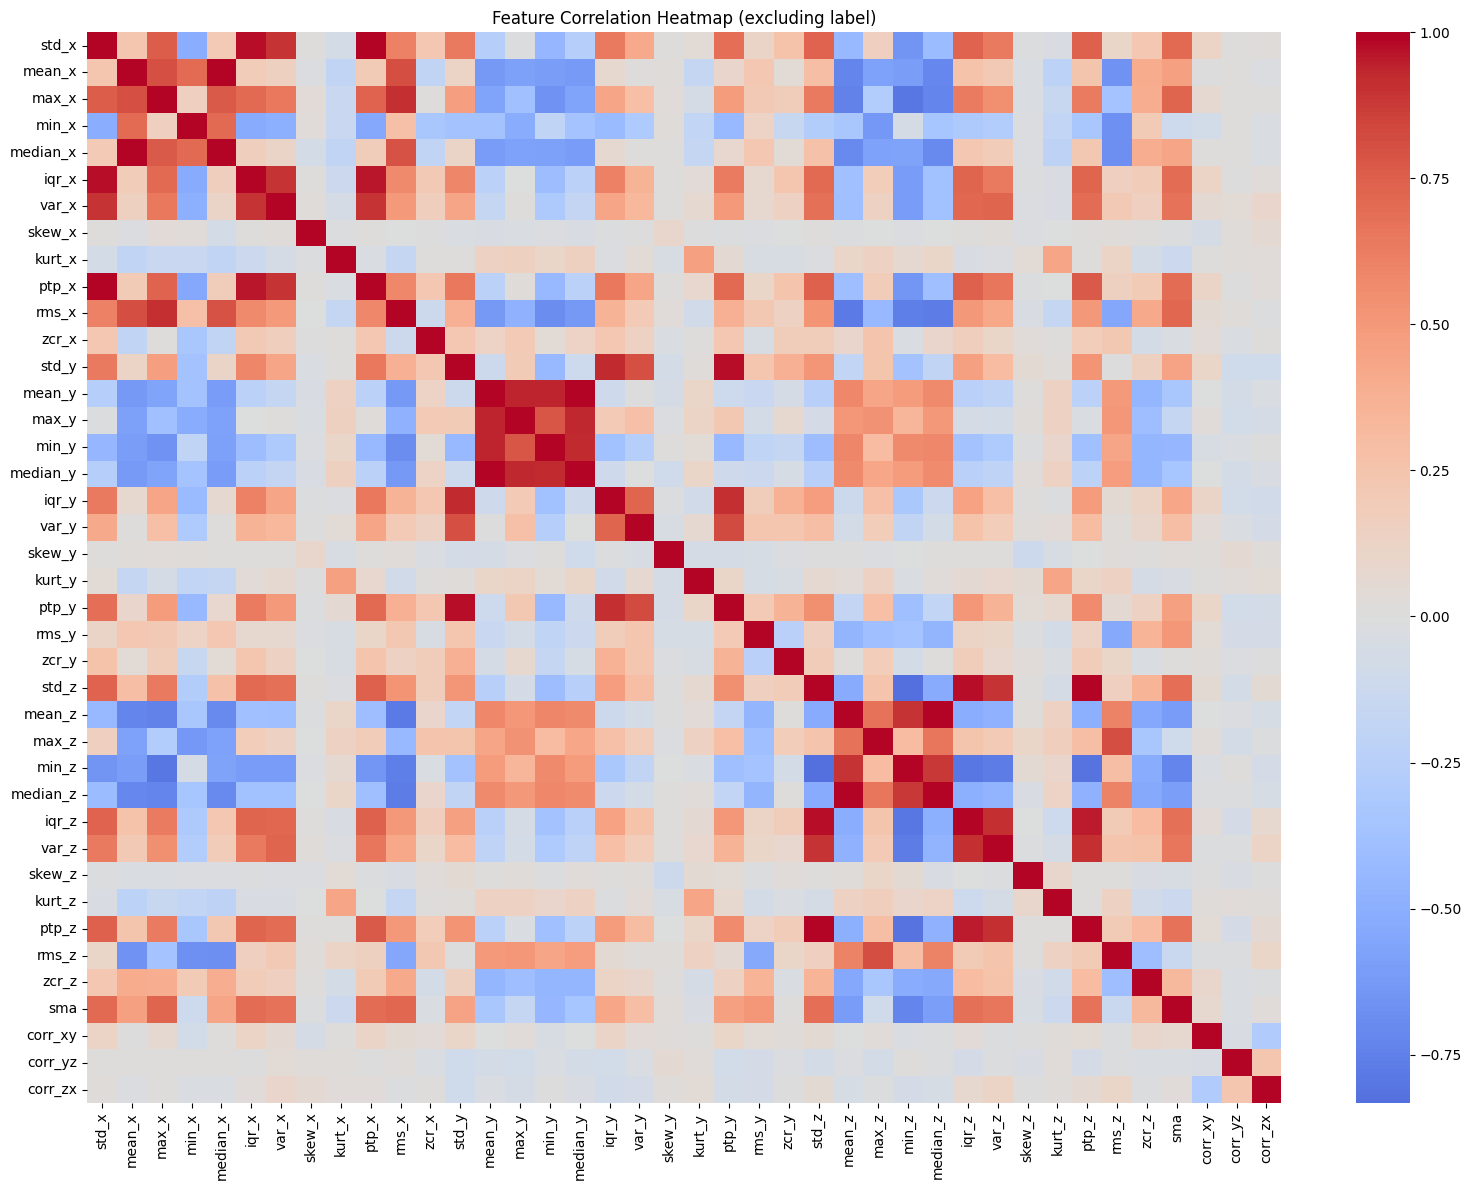

In [165]:
plot_corr(all_in_one_df)

We need to drop the belows:
- all corr_*
- all skew
- all kurt

In [41]:
drop_feats = ['skew', 'kurt']
drop_cols = [f'{stat}_{axis}' for axis in ['x', 'y', 'z'] for stat in drop_feats]
drop_cols += ['corr_xy', 'corr_yz', 'corr_zx']
drop_feats_all_in_one_df = all_in_one_df.drop(columns=drop_cols)
drop_feats_all_in_one_df.shape

(31758, 33)

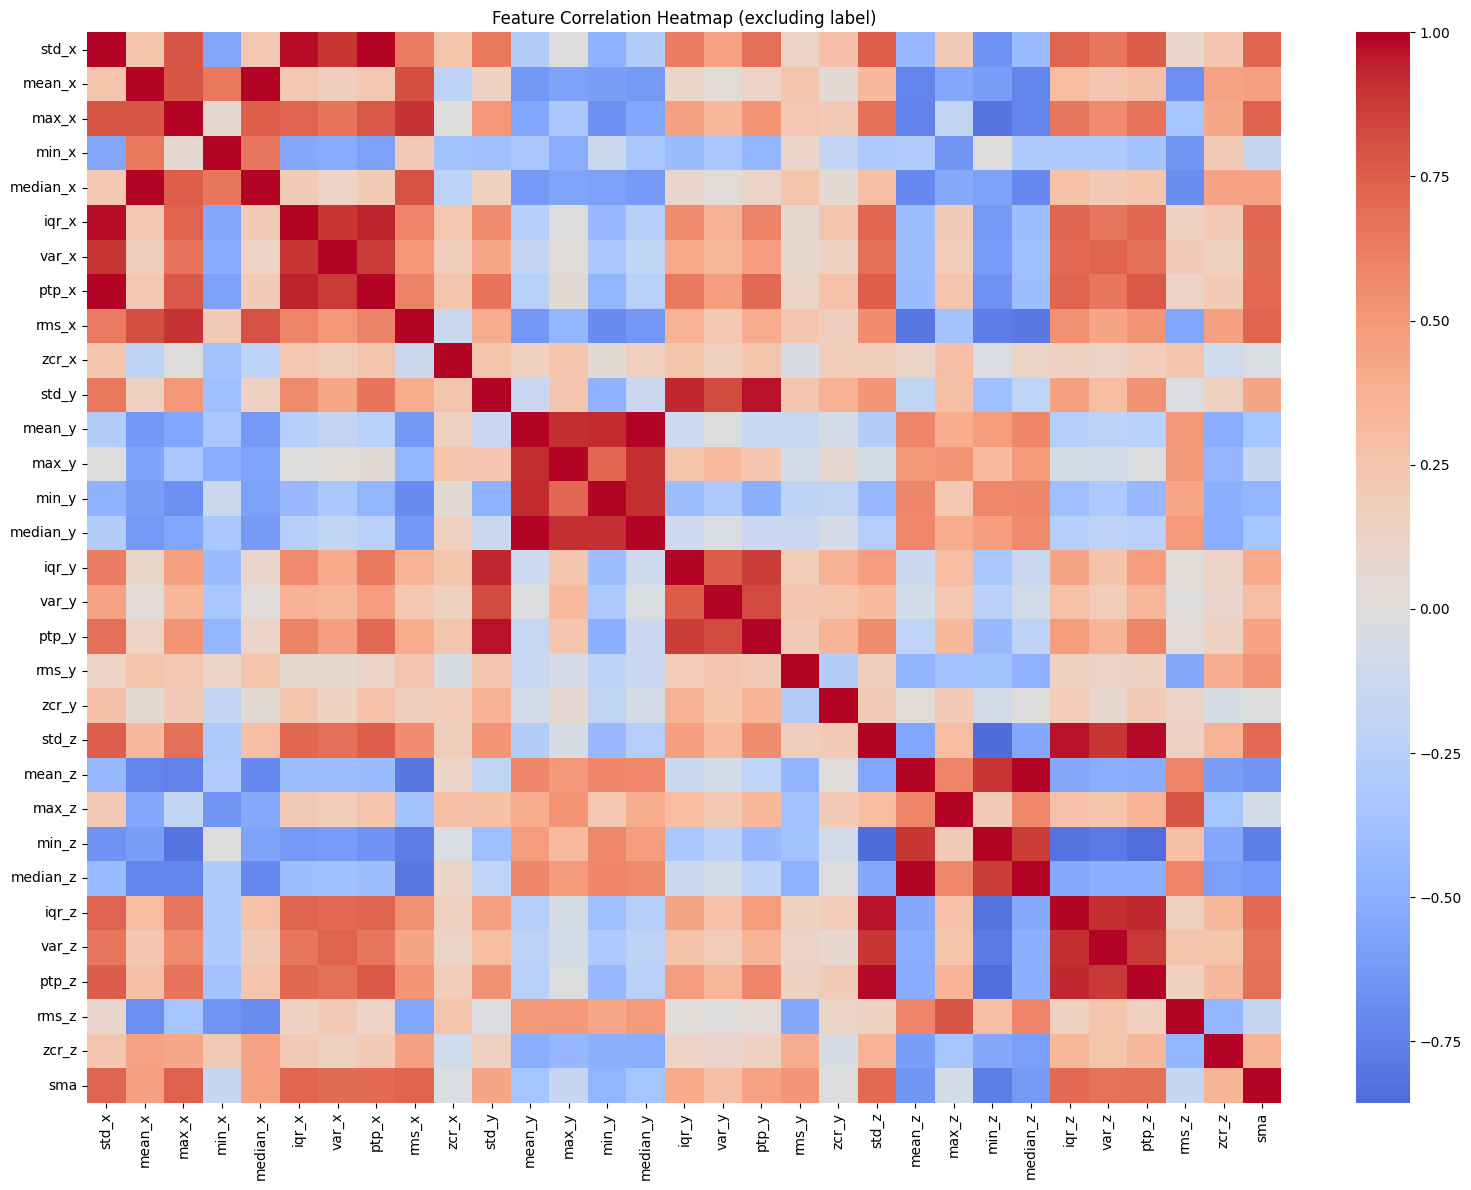

In [42]:
plot_corr(drop_feats_all_in_one_df)

# Split the data

In [166]:
X = all_in_one_df.drop(columns=['label', 'subject']).values
y = all_in_one_df['label'].values
# X = drop_feats_all_in_one_df.drop(columns=['label', 'subject']).values
# y = drop_feats_all_in_one_df['label'].values

In [ ]:
def split_by_position(X, y, start_ratio=0.0, train_ratio=0.7):
    """
    Split dataset into train/test without shuffling.
    
    Parameters:
    - X, y: features and labels
    - start_ratio: float in [0, 1), where to start the 70% slice
    - train_ratio: proportion of the data to use as training (e.g. 0.7)

    Returns:
    - X_train, X_test, y_train, y_test
    """
    assert 0 <= start_ratio < 1, "start_ratio must be in [0, 1)"
    assert 0 < train_ratio <= 1, "train_ratio must be in (0, 1]"

    total_len = len(X)
    start_index = int(start_ratio * total_len)
    end_index = start_index + int(train_ratio * total_len)

    # Handle edge case where end_index exceeds total_len
    if end_index > total_len:
        end_index = total_len

    X_train = X[start_index:end_index]
    y_train = y[start_index:end_index]

    # Use everything else for test
    X_test = np.concatenate((X[:start_index], X[end_index:]), axis=0)
    y_test = np.concatenate((y[:start_index], y[end_index:]), axis=0)

    return X_train, X_test, y_train, y_test

# X_train, X_test, y_train, y_test = split_by_position(X, y, start_ratio=0.05, train_ratio=0.7)

In [167]:
# split data into 70% training and 30% testing, while preserving the class distribution in the training set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42, stratify=y)

In [53]:
# Split without shuffling
# split_index = int(0.65 * len(X))
# X_train = X[:split_index]
# X_test = X[split_index:]
# y_train = y[:split_index]
# y_test = y[split_index:]

In [168]:
print(f'X_train_shape: {X_train.shape}, X_test_shape: {X_test.shape}')
print(f'y_train_shape: {y_train.shape}, y_test_shape: {y_test.shape}')
print(f'y_train_act_labels: {set(y_train.tolist())}\n y_test_act_labels: {set(y_test.tolist())}')

X_train_shape: (44737, 40), X_test_shape: (19174, 40)
y_train_shape: (44737,), y_test_shape: (19174,)
y_train_act_labels: {2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815}
 y_test_act_labels: {2806, 2807, 2808, 2809, 2810, 2811, 2812, 2813, 2814, 2815}


# Handling imbalanced data with different methods

In [39]:
# %pip install imblearn

## ADASYN

In [138]:
# from imblearn.over_sampling import ADASYN

# ada = ADASYN(random_state=42)

# X_resampled, y_resampled = ada.fit_resample(X_train, y_train)

# print(f'X: {X.shape}, y: {y.shape}')
# print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

## SMOTE

In [139]:
# from imblearn.over_sampling import SMOTE

# smote = SMOTE(random_state=42)

# X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# print(f'X: {X.shape}, y: {y.shape}')
# print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

X: (31758, 40), y: (31758,)
X_resampled: (34080, 40), y_resampled: (34080,)


## Random Over Sampler

In [169]:
from imblearn.over_sampling import RandomOverSampler

randomSampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = randomSampler.fit_resample(X_train, y_train)

print(f'X: {X_train.shape}, y: {y_train.shape}')
print(f'X_resampled: {X_resampled.shape}, y_resampled: {y_resampled.shape}')

X: (44737, 40), y: (44737,)
X_resampled: (68510, 40), y_resampled: (68510,)


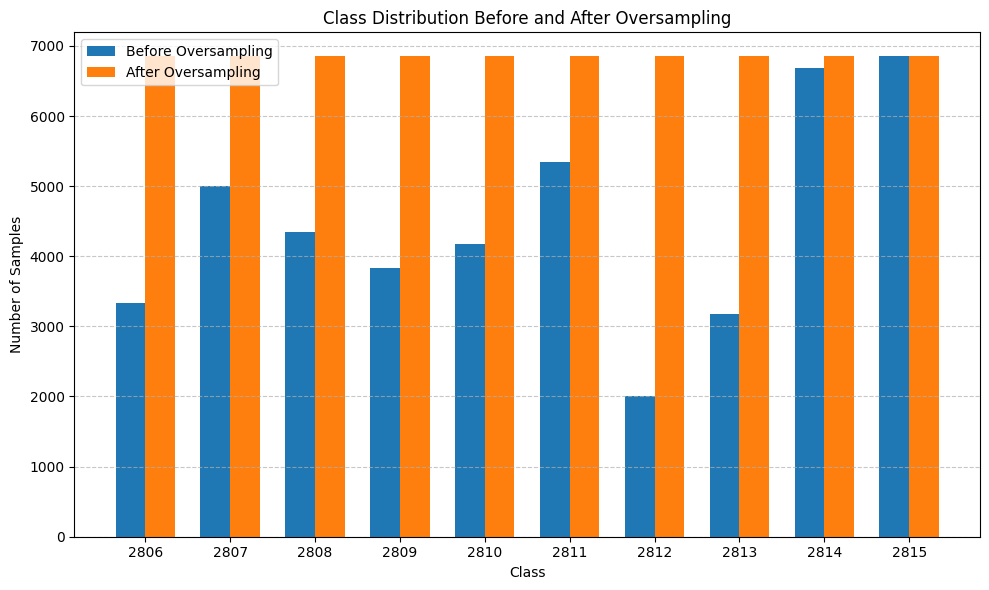

In [170]:
import matplotlib.pyplot as plt
from collections import Counter

# Count occurrences
counter_before = Counter(y_train)
counter_after = Counter(y_resampled)

# Get sorted class labels
classes = sorted(list(set(y_train)))
counts_before = [counter_before[cls] for cls in classes]
counts_after = [counter_after[cls] for cls in classes]

# Plotting
x = np.arange(len(classes))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, counts_before, width=width, label='Before Oversampling')
plt.bar(x + width/2, counts_after, width=width, label='After Oversampling')

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution Before and After Oversampling')
plt.xticks(x, classes)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Standardize the features values

In [ ]:
# standardized the features values
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# the result of scaled X with Tree-based model is not good

# Only Machine Learning, No Deep Learning

In [122]:
# for ploting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def plot_confusion_matrix(y_predict):
    # compute confusion matrix
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test, y_predict)
    # Plot with seaborn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

## LabelSpreading

              precision    recall  f1-score   support

        2806       0.34      0.43      0.38      1426
        2807       0.42      0.36      0.39      2146
        2808       0.30      0.29      0.29      1861
        2809       0.26      0.31      0.28      1645
        2810       0.34      0.35      0.34      1788
        2811       0.38      0.33      0.35      2290
        2812       0.11      0.26      0.15       859
        2813       0.29      0.36      0.32      1359
        2814       0.61      0.47      0.53      2864
        2815       0.69      0.50      0.58      2936

    accuracy                           0.38     19174
   macro avg       0.37      0.36      0.36     19174
weighted avg       0.42      0.38      0.40     19174



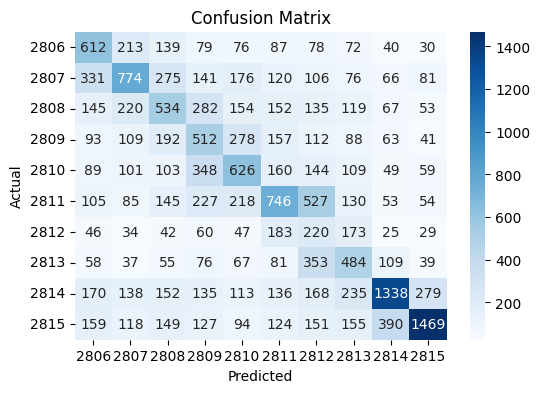

In [171]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report

# kernel_list = ['rbf', 'knn']
# max_iter_list = [50, 100, 200, 300, 1000]
# for ker in kernel_list:
#     for it in max_iter_list:
        # lspred = LabelSpreading(kernel=ker, alpha=0.5, max_iter=it)
        # lspred.fit(X_train, y_train)
        # # predict
        # y_predict = lspred.predict(X_test)
        # print(classification_report(y_test, y_predict))

lspred = LabelSpreading(kernel='knn', alpha=0.5, max_iter=50)
lspred.fit(X_resampled, y_resampled)
y_predict = lspred.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict)

## RandomForest

              precision    recall  f1-score   support

        2806       0.49      0.49      0.49      1426
        2807       0.51      0.47      0.48      2146
        2808       0.43      0.40      0.41      1861
        2809       0.28      0.31      0.29      1645
        2810       0.46      0.44      0.45      1788
        2811       0.50      0.50      0.50      2290
        2812       0.06      0.06      0.06       859
        2813       0.46      0.46      0.46      1359
        2814       0.70      0.73      0.71      2864
        2815       0.75      0.74      0.75      2936

    accuracy                           0.51     19174
   macro avg       0.46      0.46      0.46     19174
weighted avg       0.51      0.51      0.51     19174



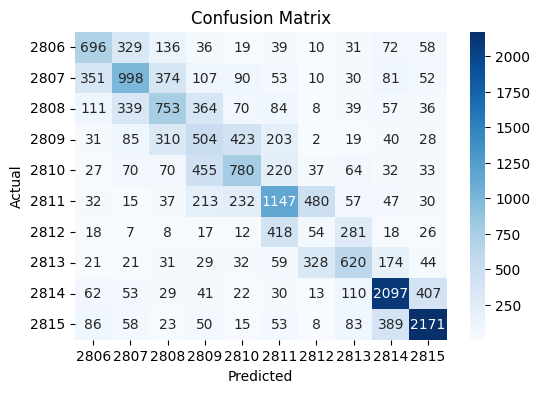

In [172]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rfc.fit(X_resampled, y_resampled)
from sklearn.metrics import classification_report
y_predict = rfc.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict)

In [129]:
test_path = '../data/TestActivities-20240920.csv'
test_df = read_act_df(test_path)
test_df.head(10)

,ID,Started,Finished,Updated,Subject
0,1156840,2024-09-09 07:47:00+09:00,2024-09-09 07:47:00+09:00,2024-09-09 07:47:00+09:00,U11
1,1156841,2024-09-09 07:47:00+09:00,2024-09-09 07:47:00+09:00,2024-09-09 07:47:00+09:00,U11
2,1156842,2024-09-09 07:47:00+09:00,2024-09-09 07:48:00+09:00,2024-09-09 07:48:00+09:00,U11
3,1156843,2024-09-09 07:48:00+09:00,2024-09-09 07:48:00+09:00,2024-09-09 07:48:00+09:00,U11
4,1156844,2024-09-09 07:48:00+09:00,2024-09-09 07:48:00+09:00,2024-09-09 07:48:00+09:00,U11
5,1156845,2024-09-09 07:48:00+09:00,2024-09-09 07:48:00+09:00,2024-09-09 07:48:00+09:00,U11
6,1156846,2024-09-09 07:48:00+09:00,2024-09-09 07:48:00+09:00,2024-09-09 07:48:00+09:00,U11
7,1156847,2024-09-09 07:48:00+09:00,2024-09-09 07:48:00+09:00,2024-09-09 07:49:00+09:00,U11
8,1156848,2024-09-09 07:48:00+09:00,2024-09-09 07:49:00+09:00,2024-09-09 07:49:00+09:00,U11
13,1164231,2024-09-11 05:14:00+09:00,2024-09-11 05:14:00+09:00,2024-09-11 05:15:00+09:00,U8


In [130]:
duration_added_test_df = add_duration(test_df)
duration_added_test_df.head(10)

,ID,Started,Finished,Updated,Subject
0,1156840,2024-09-09 07:47:00+09:00,2024-09-09 07:47:59.999999+09:00,2024-09-09 07:47:00+09:00,U11
1,1156841,2024-09-09 07:47:00+09:00,2024-09-09 07:47:59.999999+09:00,2024-09-09 07:47:00+09:00,U11
2,1156842,2024-09-09 07:47:00+09:00,2024-09-09 07:48:59.999999+09:00,2024-09-09 07:48:00+09:00,U11
3,1156843,2024-09-09 07:48:00+09:00,2024-09-09 07:48:59.999999+09:00,2024-09-09 07:48:00+09:00,U11
4,1156844,2024-09-09 07:48:00+09:00,2024-09-09 07:48:59.999999+09:00,2024-09-09 07:48:00+09:00,U11
5,1156845,2024-09-09 07:48:00+09:00,2024-09-09 07:48:59.999999+09:00,2024-09-09 07:48:00+09:00,U11
6,1156846,2024-09-09 07:48:00+09:00,2024-09-09 07:48:59.999999+09:00,2024-09-09 07:48:00+09:00,U11
7,1156847,2024-09-09 07:48:00+09:00,2024-09-09 07:48:59.999999+09:00,2024-09-09 07:49:00+09:00,U11
8,1156848,2024-09-09 07:48:00+09:00,2024-09-09 07:49:59.999999+09:00,2024-09-09 07:49:00+09:00,U11
13,1164231,2024-09-11 05:14:00+09:00,2024-09-11 05:14:59.999999+09:00,2024-09-11 05:15:00+09:00,U8


In [147]:
def seg_test(users_df, test_df):
    """
    Segmenting the dataset into one dataframe per activity
    Description:
        Each activity will has its own dataframe, which contains all the timestamps and accelerometer data within the activity time range.

    Return:
        seg_list: list of df, one df contains acceleration data of corresponding activity label
        seg_label_list: list of label. one label correspond to one df in seg_list
    
    Args:
        users_df: one big DataFrame of acceleration data
        act_df: activity labels DataFrame
    """

    seg_list = []
    seg_subject_list = []
    
    for i in range(0, len(act_df)):
        started_at = act_df.iloc[i]['Started']
        finished_at = act_df.iloc[i]['Finished']

        seg = users_df[(users_df['datetime'] >= started_at) & (users_df['datetime'] <= finished_at)]
        # seg_label = act_df.iloc[i]['Activity Type']
        # seg_label = act_df.iloc[i]['Activity Type ID']
        seg_subject = act_df.iloc[i]['Subject']

        # check if seq is not empty
        if len(seg) != 0:
            seg_list.append(seg)
            # seg_label_list.append(seg_label)
            seg_subject_list.append(seg_subject)

    return seg_list, seg_subject_list

seg_test_list, seg_test_subject_list = seg_test(users_df, duration_added_test_df)
print(f'seg_test_list: {len(seg_test_list)}, seg_test_subject_list: {len(seg_test_subject_list)}')

seg_test_list: 78, seg_test_subject_list: 78


In [150]:
seg_feats_list = []
for df in seg_test_list:
    feats = get_feats(df)
    seg_feats_list.append(feats)

seg_feats_df = pd.DataFrame(seg_feats_list, columns=all_in_one_df.drop(columns=['label', 'subject']).columns)
seg_feats_df.head(10)

,std_x,mean_x,max_x,min_x,median_x,iqr_x,var_x,skew_x,kurt_x,ptp_x,...,var_z,skew_z,kurt_z,ptp_z,rms_z,zcr_z,sma,corr_xy,corr_yz,corr_zx
0,0.86,-0.29,2.24,-3.86,-0.13,0.87,0.74,-0.85,2.30,6.10,...,0.99,-0.10,7.08,8.99,9.25,0.00,12.95,-0.07,-0.52,0.04
1,1.22,0.23,4.78,-2.32,0.18,1.36,1.48,1.06,1.46,7.10,...,1.59,-0.21,3.98,9.97,8.90,0.00,13.70,0.02,-0.51,0.01
2,1.43,0.39,4.79,-4.45,0.31,0.93,2.06,-0.02,1.68,9.23,...,1.91,1.12,5.78,14.32,8.70,0.00,13.59,-0.20,-0.68,0.16
3,1.16,0.60,6.23,-1.15,0.33,0.73,1.35,2.59,7.61,7.38,...,1.02,-0.55,2.00,7.61,8.14,0.00,14.05,-0.25,-0.65,-0.06
4,1.66,1.55,7.88,-3.00,0.96,1.88,2.74,1.05,0.85,10.88,...,2.35,-1.53,5.08,15.52,8.39,0.00,14.27,0.49,-0.72,-0.56
5,3.89,5.82,13.35,-4.78,7.23,7.96,15.14,-0.52,-0.99,18.13,...,40.49,-0.36,-0.24,33.56,7.00,0.21,16.34,-0.80,0.50,-0.82
6,4.46,4.02,14.73,-3.17,4.19,7.96,19.90,0.18,-1.17,17.91,...,12.68,0.61,-0.84,13.21,4.86,0.19,14.59,-0.68,0.62,-0.55
7,3.99,4.98,14.37,-3.47,5.16,7.13,15.90,0.12,-1.07,17.83,...,21.85,0.19,-1.51,17.90,5.95,0.32,14.54,-0.74,0.89,-0.67
8,5.01,5.39,20.35,-5.34,5.15,8.19,25.08,0.41,-0.48,25.69,...,29.33,-0.29,-0.48,27.59,6.26,0.30,17.33,-0.53,0.58,0.16
9,4.03,3.51,10.84,-2.25,0.97,8.13,16.20,0.55,-1.53,13.08,...,10.14,-0.42,-0.96,17.65,7.13,0.03,13.64,-0.58,0.38,-0.90


Predicted labels: 9


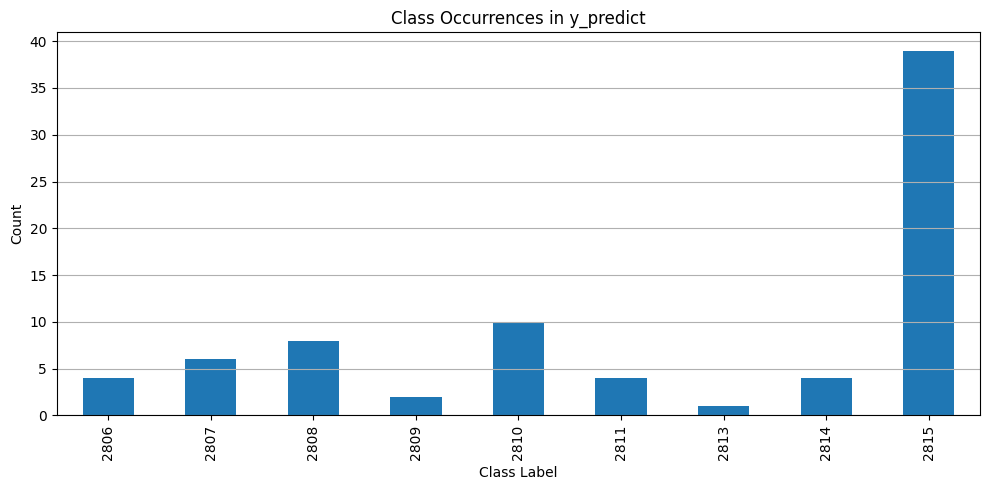

In [161]:
X_test_test = seg_feats_df.values
y_predict = rfc.predict(X_test_test)

LABELS_LIST = pd.Series(y_predict).value_counts().sort_index().index.tolist()
print(f'Predicted labels: {len(LABELS_LIST)}')

import pandas as pd
import matplotlib.pyplot as plt

# Convert predictions to pandas Series
y_pred_series = pd.Series(y_predict)

# Count occurrences of each class
class_counts = y_pred_series.value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 5))
class_counts.plot(kind='bar')
plt.title('Class Occurrences in y_predict')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## ExtraTreesClassifier

              precision    recall  f1-score   support

        2806       0.49      0.48      0.49      1426
        2807       0.50      0.46      0.48      2146
        2808       0.41      0.39      0.40      1861
        2809       0.28      0.29      0.28      1645
        2810       0.46      0.43      0.45      1788
        2811       0.50      0.49      0.50      2290
        2812       0.04      0.04      0.04       859
        2813       0.48      0.45      0.46      1359
        2814       0.68      0.76      0.72      2864
        2815       0.73      0.76      0.75      2936

    accuracy                           0.51     19174
   macro avg       0.46      0.46      0.46     19174
weighted avg       0.51      0.51      0.51     19174



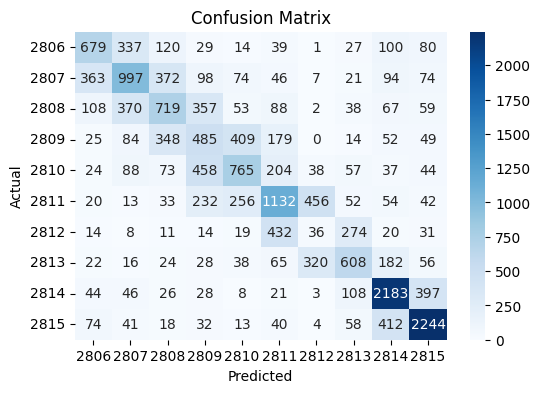

In [173]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report
etc = ExtraTreesClassifier(n_estimators=500, n_jobs=-1)
etc.fit(X_resampled, y_resampled)
y_predict = etc.predict(X_test)
print(classification_report(y_test, y_predict))
plot_confusion_matrix(y_predict)

# Deep Learning

## Convert to tensor

In [129]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [ ]:
# Pastikan input adalah float dan label adalah integer
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1)

# Encode label ke 0-9 jika belum
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [104]:
print(f'X_train_tensor: {X_train_tensor.shape}, y_train_tensor: {y_train_tensor.shape}')

X_train_tensor: torch.Size([34083, 40, 1]), y_train_tensor: torch.Size([34083])


## LSTM

In [137]:
class DeepBiLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, num_classes=10, dropout=0.3):
        super(DeepBiLSTMClassifier, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )

        self.mlp = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size * 4),  # *2 karena bidirectional
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_size * 4, hidden_size * 2),
            nn.GELU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_size * 2, num_classes)
        )

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # output: (batch, seq_len, hidden*2)
        out = lstm_out[:, -1, :]    # Ambil output timestep terakhir
        return self.mlp(out)

In [138]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepBiLSTMClassifier(
            input_size=X_train_tensor.shape[2],  # atau 12
            hidden_size=32,
            num_layers=2,
            num_classes=10,
            dropout=0.35
        ).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        optimizer.zero_grad()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

Epoch 1/1000, Loss: 2.3139
Epoch 1/1000, Loss: 2.3250
Epoch 1/1000, Loss: 2.2995
Epoch 1/1000, Loss: 2.3141
Epoch 1/1000, Loss: 2.3116
Epoch 1/1000, Loss: 2.3076
Epoch 1/1000, Loss: 2.3136
Epoch 1/1000, Loss: 2.3020
Epoch 1/1000, Loss: 2.2946
Epoch 1/1000, Loss: 2.2942
Epoch 1/1000, Loss: 2.3067
Epoch 1/1000, Loss: 2.3096
Epoch 1/1000, Loss: 2.3200
Epoch 1/1000, Loss: 2.3026
Epoch 1/1000, Loss: 2.3174
Epoch 1/1000, Loss: 2.3096
Epoch 1/1000, Loss: 2.3037
Epoch 1/1000, Loss: 2.2983
Epoch 1/1000, Loss: 2.3004
Epoch 1/1000, Loss: 2.3121
Epoch 1/1000, Loss: 2.2974
Epoch 1/1000, Loss: 2.3020
Epoch 1/1000, Loss: 2.3027
Epoch 1/1000, Loss: 2.3023
Epoch 1/1000, Loss: 2.2962
Epoch 1/1000, Loss: 2.3020
Epoch 1/1000, Loss: 2.3085
Epoch 1/1000, Loss: 2.3093
Epoch 1/1000, Loss: 2.3046
Epoch 1/1000, Loss: 2.3046
Epoch 1/1000, Loss: 2.3152
Epoch 1/1000, Loss: 2.3054
Epoch 1/1000, Loss: 2.2942
Epoch 1/1000, Loss: 2.2981
Epoch 1/1000, Loss: 2.3282
Epoch 1/1000, Loss: 2.3066
Epoch 1/1000, Loss: 2.3064
E

KeyboardInterrupt: 

In [ ]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.numpy())

all_classes = list(range(10))  # 0-9
print(classification_report(
    all_targets,
    all_preds,
    labels=all_classes,
    target_names=[f"Class {i}" for i in all_classes],
    zero_division=0
))

              precision    recall  f1-score   support

     Class 0       0.05      0.33      0.08         3
     Class 1       0.31      1.00      0.48         5
     Class 2       0.10      0.14      0.12         7
     Class 3       0.00      0.00      0.00         4
     Class 4       0.00      0.00      0.00         9
     Class 5       0.00      0.00      0.00         8
     Class 6       0.20      0.29      0.24         7
     Class 7       0.00      0.00      0.00         3
     Class 8       0.00      0.00      0.00         5
     Class 9       0.00      0.00      0.00         9

    accuracy                           0.15        60
   macro avg       0.07      0.18      0.09        60
weighted avg       0.06      0.15      0.08        60



## Transformer

In [135]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=1, d_model=128, nhead=4, num_layers=2, num_classes=10, dropout=0.25):
        super().__init__()
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model*4),
            nn.Dropout(0.2),
            nn.GELU(),
            
            nn.LayerNorm(d_model*4),
            nn.Linear(d_model*4, d_model),
            nn.Dropout(0.2),
            nn.GELU(),
            nn.Linear(d_model, num_classes)
        )

    def forward(self, x):
        # x: (batch, seq_len, input_dim) → (16, 12, 1)
        x = self.input_projection(x)       # → (16, 12, d_model)
        x = self.pos_encoder(x)            # positional encoding
        x = x.transpose(0, 1)              # → (seq_len, batch, d_model)
        x = self.transformer_encoder(x)    # → (seq_len, batch, d_model)
        x = x.mean(dim=0)                  # mean pooling over time steps → (batch, d_model)
        return self.classifier(x)          # → (batch, num_classes)

In [ ]:
from torch.optim.lr_scheduler import OneCycleLR

model = TransformerClassifier(
            input_dim=1, 
            d_model=256, 
            nhead=16, 
            num_layers=2, 
            num_classes=10,
            dropout=0.2
        ).to(device)

num_epochs = 200
max_lr = 3e-4
clip_value = 3
steps_per_epoch = len(train_loader)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=max_lr)


scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    pct_start=0.1,  # % of total steps to increase the LR
    anneal_strategy='cos',  # cosine annealing after max_lr
    div_factor=10.0,  # initial_lr = max_lr / div_factor
    final_div_factor=100  # final_lr = initial_lr / final_div_factor
)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()
        scheduler.step()  # Step the OneCycle scheduler
        print(scheduler.get_last_lr())


        running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / steps_per_epoch:.4f}")

/Users/tptn/MachineLearning/tremor_challenge2/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[0.00010000001954561485]
Epoch 1/200, Loss: 0.0044
[0.00010000007818245752]
Epoch 1/200, Loss: 0.0088
[0.00010000017591052317]
Epoch 1/200, Loss: 0.0132
[0.00010000031272980315]
Epoch 1/200, Loss: 0.0176
[0.00010000048864028561]
Epoch 1/200, Loss: 0.0219
[0.00010000070364195519]
Epoch 1/200, Loss: 0.0263
[0.00010000095773479332]
Epoch 1/200, Loss: 0.0305
[0.00010000125091877779]
Epoch 1/200, Loss: 0.0348
[0.00010000158319388344]
Epoch 1/200, Loss: 0.0391
[0.000100001954560081]
Epoch 1/200, Loss: 0.0434
[0.00010000236501733837]
Epoch 1/200, Loss: 0.0477
[0.00010000281456562011]
Epoch 1/200, Loss: 0.0519
[0.00010000330320488685]
Epoch 1/200, Loss: 0.0562
[0.00010000383093509643]
Epoch 1/200, Loss: 0.0607
[0.00010000439775620265]
Epoch 1/200, Loss: 0.0650
[0.00010000500366815661]
Epoch 1/200, Loss: 0.0693
[0.00010000564867090542]
Epoch 1/200, Loss: 0.0734
[0.00010000633276439333]
Epoch 1/200, Loss: 0.0776
[0.00010000705594856072]
Epoch 1/200, Loss: 0.0818
[0.00010000781822334481]
Epoch 1/

KeyboardInterrupt: 

In [68]:
y_batch

tensor([2, 5, 6, 5, 0, 6, 0, 2, 4, 9, 7, 2, 4, 0, 6, 6, 5, 3, 3, 4, 9, 5, 2, 8,
        4, 4, 0, 0, 6, 2, 4, 1])

In [ ]:
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(y_batch.numpy())

all_classes = list(range(10))  # 0-9
print(classification_report(
    all_targets,
    all_preds,
    labels=all_classes,
    target_names=[f"Class {i}" for i in all_classes],
    zero_division=0
))

              precision    recall  f1-score   support

     Class 0       0.17      0.25      0.20         8
     Class 1       1.00      0.50      0.67         8
     Class 2       0.25      0.12      0.17         8
     Class 3       0.75      0.38      0.50         8
     Class 4       0.38      0.38      0.38         8
     Class 5       0.17      0.12      0.14         8
     Class 6       0.33      0.38      0.35         8
     Class 7       0.42      0.56      0.48         9
     Class 8       0.38      0.62      0.48         8
     Class 9       0.33      0.38      0.35         8

    accuracy                           0.37        81
   macro avg       0.42      0.37      0.37        81
weighted avg       0.42      0.37      0.37        81



# Experimenting with Lazy Predict

In [91]:
# %pip install lazypredict
# %pip install ipywidgets

In [91]:
from lazypredict.Supervised import LazyClassifier

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_resampled, X_test, y_resampled, y_test)

print(models)

  0%|          | 0/32 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10198
[LightGBM] [Info] Number of data points in the train set: 32030, number of used features: 40
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
[LightGBM] [Info] Start training from score -2.302585
                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                     